In [1]:
import pandas as pd
import random as rd
import numpy as np
import copy
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import collections
from collections import deque, defaultdict

In [2]:
class QTable:
    def __init__(self):
        self.Q = defaultdict(lambda: defaultdict(lambda: 0.0))
    
    def _state_to_tuple(self, state):
        return tuple(sorted((edge, tuple(sorted(ages))) for edge, ages in state.items()))
    
    def storeStateActionValue(self, state, action, value):
        state_tuple = self._state_to_tuple(state)
        action_tuple = tuple(tuple(edge) for edge in action)
        self.Q[state_tuple][action_tuple] = value
    
    def getValue(self, state, action):
        state_tuple = self._state_to_tuple(state)
        action_tuple = tuple(tuple(edge) for edge in action)
        return self.Q[state_tuple][action_tuple]
    
    def getActionAndValues(self, state):
        state_tuple = self._state_to_tuple(state)
        return [(action, value) for action, value in self.Q[state_tuple].items()]


def epsilonGreedyPolicy(Q, state, epsilon, env):
    actions_and_values = Q.getActionAndValues(state)
    
    if not actions_and_values:
        possible_actions = env.getPossibleActions()
        return rd.choice(possible_actions)
    
    if np.random.rand() < epsilon:
        return random.choice(actions_and_values)[0]
    else:
        return max(actions_and_values, key=lambda x: x[1])[0]



In [3]:
class QuantumNetwork:
    def __init__(self, initialEdges, pGen, pSwap, cutOffAge, nodeCapacity):
        self.initialEdges = initialEdges
        self.pGen = pGen
        self.pSwap = pSwap
        self.cutOffAge = cutOffAge
        self.nodeCapacity = nodeCapacity  # Dictionary mapping node -> max entanglements
        
        self.G = nx.Graph()
        nodes = set()
        for edge in self.initialEdges:
            nodes.add(edge[0])
            nodes.add(edge[1])
        self.G.add_nodes_from(sorted(nodes))
    
    def reset(self):
        self.G = nx.Graph()
        nodes = set()
        for edge in self.initialEdges:
            nodes.add(edge[0])
            nodes.add(edge[1])
        self.G.add_nodes_from(nodes)
    
    def setState(self, state):
        self.G = nx.Graph()
        for edge, entanglements in state.items():
            self.G.add_edge(*edge, entanglements=deque(entanglements))
    
    def getNodeEntanglementCount(self, node):
        """Count total entanglements a node is involved in"""
        return sum(len(self.G.edges[e]['entanglements']) 
                  for e in self.G.edges(node)) if self.G.degree(node) > 0 else 0
        
    def generateLocalEntanglement(self, node1, node2):
        edge = tuple(sorted([node1, node2]))
        
        # Check if either node has reached its capacity
        node1_count = self.getNodeEntanglementCount(node1)
        node2_count = self.getNodeEntanglementCount(node2)
        
        if (node1_count >= self.nodeCapacity[node1] or 
            node2_count >= self.nodeCapacity[node2]):
            return 
        
        if not self.G.has_edge(*edge):
            self.G.add_edge(*edge, entanglements=deque([0]))
        else:
            self.G.edges[edge]['entanglements'].appendleft(0)
            
    def getState(self):
        edge_info = {}
        for edge in self.G.edges():
            edge_info[edge] = list(self.G.edges[edge]['entanglements']) 
        return edge_info
        
    def ageEntanglements(self):
        edges_to_check = list(self.G.edges())  # Create a copy of edges to iterate over
        for edge in edges_to_check:
            entanglements = self.G.edges[edge]['entanglements']
            # Remove entanglements that would exceed cutOffAge
            while entanglements and entanglements[-1] + 1 > self.cutOffAge:
                self.discardEntanglement(edge)
            # Age remaining entanglements
            if self.G.has_edge(*edge):  # Check if edge still exists
                entanglements = self.G.edges[edge]['entanglements']
                self.G.edges[edge]['entanglements'] = deque(age + 1 for age in entanglements)
    
    def generateGlobalEntanglementsProbabalistically(self):
        for edge in self.initialEdges:
            if rd.random() < self.pGen:
                self.generateLocalEntanglement(*edge)
    
    # def generateLocalEntanglement(self, node1, node2):
    #     edge = tuple(sorted([node1, node2]))
        
    #     node1_entanglements = sum(len(self.G.edges[e]['entanglements']) 
    #                             for e in self.G.edges(node1)) if self.G.degree(node1) > 0 else 0
    #     node2_entanglements = sum(len(self.G.edges[e]['entanglements']) 
    #                             for e in self.G.edges(node2)) if self.G.degree(node2) > 0 else 0
        
    #     if node1_entanglements >= self.maxLinks or node2_entanglements >= self.maxLinks:
    #         return 
        
    #     if not self.G.has_edge(*edge):
    #         self.G.add_edge(*edge, entanglements=deque([0]))
    #     else:
    #         if len(self.G.edges[edge]['entanglements']) < self.maxLinks:
    #             self.G.edges[edge]['entanglements'].appendleft(0)
    
    def discardEntanglement(self, edge: tuple):
        if self.G.has_edge(*edge):
            if len(self.G.edges[edge]['entanglements']) > 0:
                self.G.edges[edge]['entanglements'].pop()
            if len(self.G.edges[edge]['entanglements']) == 0:
                self.G.remove_edge(*edge)
                
         
    def drawNetwork(self):
        plt.figure(figsize=(12, 8))
        plt.clf()
        
        G_viz = self.G.copy()
        G_viz.add_edges_from(self.initialEdges)
        
        # FIXED POSITION FOR DUMBELL NETWORK
        pos = {
            0: (-1, 0.5),   # Top left
            1: (-1, -0.5),  # Bottom left
            2: (0, 0),      # Center
            3: (1, 0),      # Center right
            4: (2, 0.5),    # Top right
            5: (2, -0.5)    # Bottom right
        }
        # pos = nx.spring_layout(G_viz, seed=27)

        nx.draw_networkx_edges(G_viz, pos=pos, 
                            edgelist=self.initialEdges,
                            edge_color='grey',
                            style='dashed',
                            alpha=0.5)
        
        for edge in self.G.edges():
            entanglements = self.G.edges[edge]['entanglements']
            for i, age in enumerate(entanglements):
                nx.draw_networkx_edges(G_viz, pos=pos,
                                    edgelist=[edge],
                                    edge_color='blue',
                                    width=2,
                                    arrows=True,
                                    connectionstyle=f'arc3, rad={-0.1 + i*0.2}')
                
                edge_x = (pos[edge[0]][0] + pos[edge[1]][0]) / 2
                edge_y = (pos[edge[0]][1] + pos[edge[1]][1]) / 2
                offset = -0.1 + i*0.2
                label_x = edge_x + offset * (pos[edge[1]][1] - pos[edge[0]][1]) / 2
                label_y = edge_y - offset * (pos[edge[1]][0] - pos[edge[0]][0]) / 2
                plt.text(label_x, label_y, str(age), 
                        bbox=dict(facecolor='white', edgecolor='lightgray', alpha=0.7))
        
        nx.draw_networkx_nodes(G_viz, pos=pos, node_color='lightblue')
        nx.draw_networkx_labels(G_viz, pos=pos)
        
        plt.show()

###############################
###############################
###############################

class WaitSwapEnvironment(QuantumNetwork):
    def __init__(self, initialEdges, pGen, pSwap, cutOffAge, nodeCapacity, goalEdgesAndWeights, nStepsDepth, gamma):
        super().__init__(initialEdges, pGen, pSwap, cutOffAge, nodeCapacity)
        self.goalEdgesAndWeights = goalEdgesAndWeights
        self.timestep = 0  # Track total timesteps
        self.sumExists = defaultdict(lambda: 0)  # Track sum of times each goal edge exists
        self.nStepsDepth = nStepsDepth  # Ensure this line is present
        self.gamma = gamma
        
    def getReward(self):
        total_reward = 0
        
        for goal_edge, weight in self.goalEdgesAndWeights:
            sorted_goal = tuple(sorted(goal_edge))
            
            if self.G.has_edge(*sorted_goal):
                # Basic, generic version
                path = nx.shortest_path(self.G, sorted_goal[0], sorted_goal[1])
                num_elementary_edges = len(path) - 1
                
                instantaneousRate = self.pSwap ** num_elementary_edges
    
                # Calculate average rate directly
                if self.timestep > 0:
                    if self.sumExists[sorted_goal] > 0:
                        averageRate = self.sumExists[sorted_goal] / self.timestep
                    else:
                        averageRate = 1  # Fallback to avoid division by zero
                else:
                    averageRate = 1  # Default to 1.0 if timestep is zero to avoid division by zero
                
                edge_reward = (instantaneousRate / averageRate) * weight
                
                total_reward += edge_reward

        return total_reward

    def updateRateParameters(self):
        for goal_edge, _ in self.goalEdgesAndWeights:
            sorted_goal = tuple(sorted(goal_edge))
            self.sumExists[sorted_goal] += int(self.G.has_edge(*sorted_goal))
    
    def copy(self):
        new_env = WaitSwapEnvironment(
            initialEdges=self.initialEdges.copy(),  # Use copy to ensure a new list is created
            pGen=self.pGen,
            pSwap=self.pSwap,
            cutOffAge=self.cutOffAge,
            nodeCapacity=self.nodeCapacity,
            goalEdgesAndWeights=self.goalEdgesAndWeights,
            nStepsDepth=self.nStepsDepth,
            gamma=self.gamma  # Include the gamma parameter
        )
        
        # Copy the current graph state
        new_env.G = self.G.copy()
        
        # Copy the entanglements for each edge
        for edge in new_env.G.edges():
            new_env.G.edges[edge]['entanglements'] = deque(self.G.edges[edge]['entanglements'])
        
        # Copy tracking variables
        new_env.timestep = self.timestep
        new_env.sumExists = self.sumExists.copy()
        
        return new_env

    def takeAction(self, action):
        if action['swaps']: 
            # Get the ages of all edges involved in swaps
            max_age = 0
            for edge1, edge2 in action['swaps']:
                if self.G.has_edge(*edge1):
                    max_age = max(max_age, max(self.G.edges[edge1]['entanglements']))
                if self.G.has_edge(*edge2):
                    max_age = max(max_age, max(self.G.edges[edge2]['entanglements']))
                
                self.discardEntanglement(edge1)
                self.discardEntanglement(edge2)

            if action['goal']:
                # Create goal entanglement with the maximum age
                edge = tuple(sorted(action['goal']))
                if not self.G.has_edge(*edge):
                    self.G.add_edge(*edge, entanglements=deque([max_age]))
                else:
                    self.G.edges[edge]['entanglements'].appendleft(max_age)
        
        final_state = self.getState()
        return final_state

    def step(self):
        # Organic step without action
        self.ageEntanglements()
        self.generateGlobalEntanglementsProbabalistically()
        self.timestep += 1

    
    def recursiveLookahead(self, depth):
        if depth == self.nStepsDepth:
            return self.getReward()
    
        possibleActions = self.getPossibleActions()
        totalReward = 0
        for action in possibleActions:
            tempNetwork = self.copy()
            tempNetwork.takeAction(action)
            tempNetwork.step()
            reward = self.getReward() + (self.gamma ** depth) * tempNetwork.recursiveLookahead(depth + 1)
            totalReward += reward

        return totalReward 
    
    def getPossibleActions(self):
        possible_actions = []
        
        for goal_edge, _ in self.goalEdgesAndWeights:
            start_node, end_node = goal_edge
            
            if nx.has_path(self.G, start_node, end_node):
                paths = list(nx.all_simple_paths(self.G, start_node, end_node))
                for path in paths:
                    # Get all edges in the path, always sorted
                    path_edges = []
                    for i in range(len(path)-1):
                        edge = tuple(sorted([path[i], path[i+1]]))
                        path_edges.append(edge)
                    
                    # Check if all edges exist in graph (accounting for either order)
                    has_entanglements = all(
                        self.G.has_edge(*edge) or self.G.has_edge(*tuple(reversed(edge)))
                        for edge in path_edges
                    )
                    
                    if has_entanglements:
                        possible_actions.append({
                            'swaps': [(edge1, edge2) for edge1, edge2 in zip(path_edges[:-1], path_edges[1:])],
                            'goal': goal_edge
                        })
        
        possible_actions.append({
            'swaps': [],
            'goal': None
        })

        return possible_actions

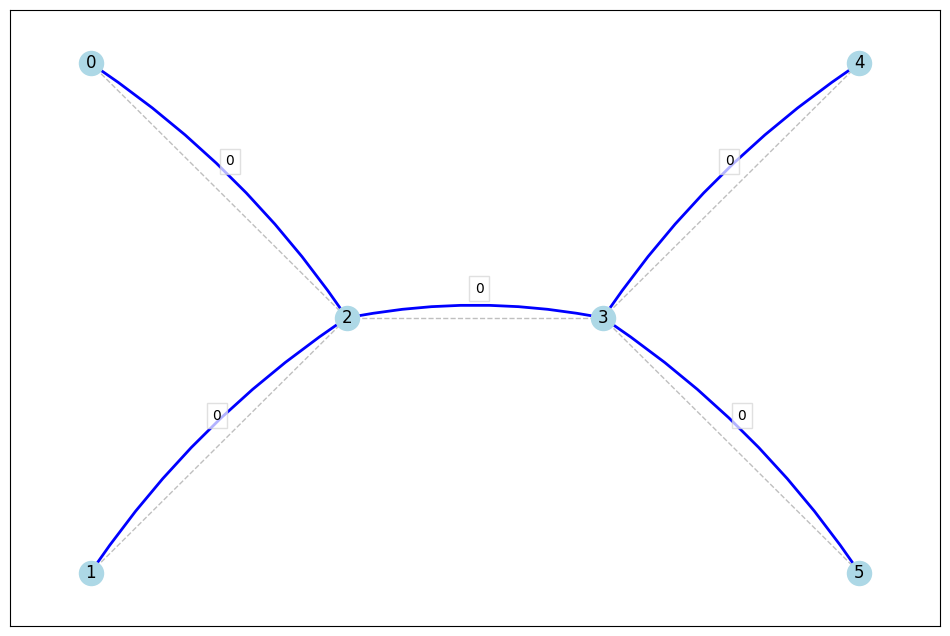

Initial State:{(0, 2): [0], (1, 2): [0], (2, 3): [0], (3, 4): [0], (3, 5): [0]}
Possible Actions:[{'swaps': [((0, 2), (2, 3)), ((2, 3), (3, 5))], 'goal': (0, 5)}, {'swaps': [((1, 2), (2, 3)), ((2, 3), (3, 4))], 'goal': (1, 4)}, {'swaps': [], 'goal': None}]
----------------------------------------------------------------------------------------------------
defaultdict(<function WaitSwapEnvironment.__init__.<locals>.<lambda> at 0x12f99f920>, {(0, 5): 1, (1, 4): 0})
1
Action: {'swaps': [], 'goal': (0, 5)}, Lookahead Reward: 2.1009065023401017
Action: {'swaps': [((1, 2), (2, 3)), ((2, 3), (3, 4))], 'goal': (1, 4)}, Lookahead Reward: 3.0051000026900176
Action: {'swaps': [], 'goal': None}, Lookahead Reward: 2.1009000044500605
defaultdict(<function WaitSwapEnvironment.__init__.<locals>.<lambda> at 0x12f99f920>, {(0, 5): 1, (1, 4): 0})
1


In [8]:
# For some reason, the seed needs to be set here, otherwise the results are different every time
SEED = 1
rd.seed(SEED)
np.random.seed(SEED)

# Initalise Network
nodeCapacity = {
    0: 1,  
    1: 1,  
    2: 3,  
    3: 3, 
    4: 1,  
    5: 1
}
initialEdges = [
    (0, 2),
    (1, 2),
    (2, 3),
    (3, 4),
    (3, 5)]
goalEdgesAndWeights = [((0,5), 0.7), ((1,4), 0.3)]
network = WaitSwapEnvironment(initialEdges=initialEdges, gamma=0.1,pGen=0.8,pSwap=1, cutOffAge=1, nodeCapacity=nodeCapacity, goalEdgesAndWeights=goalEdgesAndWeights, nStepsDepth=10) 

network.generateGlobalEntanglementsProbabalistically()
network.generateGlobalEntanglementsProbabalistically()

network.drawNetwork()
print(f"Initial State:{network.getState()}")
myActions = network.getPossibleActions()
print(f"Possible Actions:{myActions}")
print(50 *'--')
network.takeAction(myActions[0])
network.updateRateParameters()
network.step()
print(network.sumExists)
print(network.timestep)

myActions = network.getPossibleActions()

for action in myActions:
    tempNetwork = network.copy()
    tempNetwork.takeAction(action)
    lookaheadReward = tempNetwork.recursiveLookahead(depth=1)
    print(f'Action: {action}, Lookahead Reward: {lookaheadReward}')

print(network.sumExists)
print(network.timestep)



In [5]:
# def nStepQLearning(network, Q, numEpisodes, n, gamma, epsilon, maxSteps):
#     episodeRewards = np.zeros(numEpisodes) 
#     episodeLengths = np.zeros(numEpisodes)  
    
#     for episode in range(numEpisodes):
#         print(f"Episode {episode + 1} of {numEpisodes}")
#         # Reset the network, generate initial entanglements
#         network.reset()
#         network.generateGlobalEntanglementsProbabalistically()
#         # Initial States
#         state = network.getState() # Current State
#         actions = epsilonGreedyPolicy(Q, state, epsilon)
        